## **1.** ¿Qué es la estandarización y cuándo usarla?

**Estandarizar** transforma variables continuas para que sean comparables entre sí.  
Dos técnicas habituales:

- **Escalado (scaling)**: p. ej. `StandardScaler` (media 0, desviación 1) o `MinMaxScaler` (rango 0–1).  
  Útil cuando el modelo usa distancias o supuestos lineales (KNN, regresión lineal, K-means).
- **Normalización logarítmica** (p. ej. `np.log1p`) para variables con mucha asimetría o valores muy grandes (skew / long tail).

**Cuándo estandarizar** (reglas prácticas):
- Modelos que usan **distancias** o trabajan en espacio lineal → escalar.
- Variables con **varianzas muy distintas** → escalar para evitar que una domine.
- Variables con **distribución sesgada** (colas largas) → aplicar log antes del escalado.

A continuación hay ejemplos didácticos (código) que muestran:
1. Dos variables en escalas muy distintas (nº habitaciones vs precio) y el efecto de `StandardScaler`.  
2. Una variable con cola larga y el efecto de `log1p` + escalado.


In [37]:
# Ejemplo 1: efecto de StandardScaler cuando las variables están en escalas muy diferentes
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Datos de ejemplo: 8 observaciones
df = pd.DataFrame({
    "bedrooms": [1,2,3,2,4,3,2,1],           # pequeña escala (1-4)
    "last_sale_price": [120000, 350000, 250000, 400000, 600000, 310000, 220000, 150000]
})

print("Resumen antes de escalar:")
print(df.describe().loc[['mean','std','min','max']])

df

Resumen antes de escalar:
      bedrooms  last_sale_price
mean  2.250000    300000.000000
std   1.035098    154179.857866
min   1.000000    120000.000000
max   4.000000    600000.000000


,bedrooms,last_sale_price
0,1,120000
1,2,350000
2,3,250000
3,2,400000
4,4,600000
5,3,310000
6,2,220000
7,1,150000


**Aplicación de una normalización Z-score a todo el DataFrame**

In [38]:
# Aplicar StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

print("\nResumen después de StandardScaler (media ≈ 0, std ≈ 1):")
print(df_scaled.describe().loc[['mean','std','min','max']])

df_scaled


Resumen después de StandardScaler (media ≈ 0, std ≈ 1):
      bedrooms  last_sale_price
mean  0.000000     2.775558e-17
std   1.069045     1.069045e+00
min  -1.290994    -1.248075e+00
max   1.807392     2.080126e+00


,bedrooms,last_sale_price
0,-1.290994,-1.248075
1,-0.258199,0.346688
2,0.774597,-0.346688
3,-0.258199,0.693375
4,1.807392,2.080126
5,0.774597,0.069338
6,-0.258199,-0.554700
7,-1.290994,-1.040063


**Aplicación de una normalización Min-Max**

In [39]:
# Aplicar MinMaxScaler para ver otra alternativa
mms = MinMaxScaler()
df_minmax = pd.DataFrame(mms.fit_transform(df), columns=df.columns)
print("\nResumen después de MinMaxScaler (rango 0-1):")
print(df_minmax.describe().loc[['mean','std','min','max']])

df_minmax


Resumen después de MinMaxScaler (rango 0-1):
      bedrooms  last_sale_price
mean  0.416667         0.375000
std   0.345033         0.321208
min   0.000000         0.000000
max   1.000000         1.000000


,bedrooms,last_sale_price
0,0.000000,0.000000
1,0.333333,0.479167
2,0.666667,0.270833
3,0.333333,0.583333
4,1.000000,1.000000
5,0.666667,0.395833
6,0.333333,0.208333
7,0.000000,0.062500


**Cuando tenemos datos que hay valores muy altos, por ejemplo que siguen una distribución exponencial, otra alternativa es:**
- **Aplanar los datos con una normalización logarítmica**
- **Hacer un escalado Z-score a los datos normalizados logarítmicamente**

In [40]:
# Ejemplo 2: variable con cola larga (skew) y cómo ayuda log1p antes de escalar
import matplotlib.pyplot as plt

# Generar datos con cola larga (simula ingresos o ventas)
# Ese bloque de código genera un conjunto de datos sesgado hacia la derecha (right-skewed)
#usando una distribución exponencial, y luego le agrega unos valores muy grandes atípicos (outliers)

rng = np.random.default_rng(0) # crea un generador de números aleatorios
# Genera 400 números aleatorios siguiendo una distribución exponencial con parámetro
skew_vals = np.concatenate([rng.exponential(scale=1.0, size=400)*1000, [20000, 50000, 100000]])

df2 = pd.DataFrame({"valor": skew_vals})

print("Estadísticas antes de log:")
print(df2['valor'].describe())

df2

Estadísticas antes de log:
count       403.000000
mean       1539.912597
std        5669.671984
min           0.487348
25%         346.618619
50%         801.730176
75%        1671.649395
max      100000.000000
Name: valor, dtype: float64


,valor
0,679.931904
1,1019.597101
2,19.806663
3,2.269327
4,550.342873
...,...
398,1783.158576
399,1049.748174
400,20000.000000
401,50000.000000


In [41]:
# 1) Escalado directo (no recomendado si hay mucha asimetría)
scaler2 = StandardScaler()
df2['z_direct'] = scaler2.fit_transform(df2[['valor']])


# Ordenamos df2 por el valor "z_direct"
df2 = df2.sort_values(by='z_direct')
df2

,valor,z_direct
256,0.487348,-0.271857
11,1.287750,-0.271715
3,2.269327,-0.271542
346,6.650101,-0.270768
140,10.924276,-0.270014
...,...,...
249,6928.464554,0.951598
295,8128.754307,1.163565
400,20000.000000,3.259983
401,50000.000000,8.557871


In [42]:
# 2) Log-normalización + escalado
df2['log_valor'] = np.log1p(df2['valor']) # aplica una transformación logarítmica
df2.sort_values('log_valor')

,valor,z_direct,log_valor
256,0.487348,-0.271857,0.396995
11,1.287750,-0.271715,0.827569
3,2.269327,-0.271542,1.184584
346,6.650101,-0.270768,2.034719
140,10.924276,-0.270014,2.478576
...,...,...,...
249,6928.464554,0.951598,8.843538
295,8128.754307,1.163565,9.003286
400,20000.000000,3.259983,9.903538
401,50000.000000,8.557871,10.819798


In [43]:
# Aplicamos StandardScaler a la columna 'log_valor'
scaler3 = StandardScaler()
df2['z_log'] = scaler3.fit_transform(df2[['log_valor']])

print("\nEstadísticas después de log (antes de escalar):")
df2['log_valor'].describe()


Estadísticas después de log (antes de escalar):


count    403.000000
mean       6.488988
std        1.363885
min        0.396995
25%        5.851104
50%        6.688019
75%        7.422164
max       11.512935
Name: log_valor, dtype: float64

In [44]:
df2['log_valor'].var()

np.float64(1.860181853805201)

In [45]:
print("\nEstadísticas después de log (después de escalar):")
df2['z_log'].describe()


Estadísticas después de log (después de escalar):


count    4.030000e+02
mean    -2.821013e-16
std      1.001243e+00
min     -4.472199e+00
25%     -4.682772e-01
50%      1.461109e-01
75%      6.850550e-01
max      3.688136e+00
Name: z_log, dtype: float64

In [46]:
df2['z_log'].var()

np.float64(1.0024875621890545)

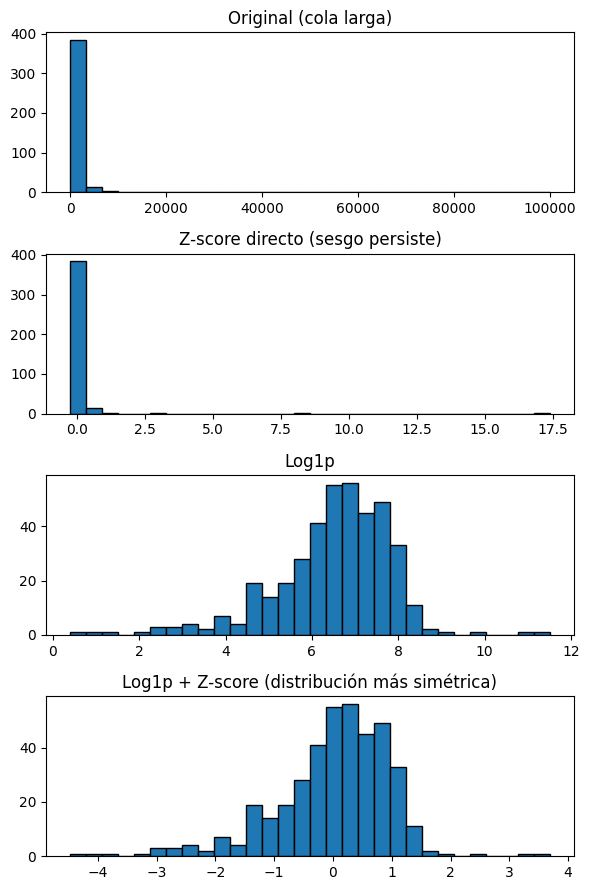

In [47]:
# Mostrar histogramas para comparar
fig, axes = plt.subplots(4,1, figsize=(6,9))
axes[0].hist(df2['valor'], bins=30, edgecolor='k') #grafico en parte superior, con 30 barras, con bordes negros
axes[0].set_title('Original (cola larga)')
axes[1].hist(df2['z_direct'], bins=30, edgecolor='k') #grafico en parte media
axes[1].set_title('Z-score directo (sesgo persiste)')
axes[2].hist(df2['log_valor'], bins=30, edgecolor='k') #grafico en parte inferior
axes[2].set_title('Log1p')
axes[3].hist(df2['z_log'], bins=30, edgecolor='k') #grafico en parte inferior
axes[3].set_title('Log1p + Z-score (distribución más simétrica)')
plt.tight_layout()
plt.show()


### Consejos prácticos

- Si tu modelo usa distancias (KNN, K-means) o regresión lineal: **escala** las variables numéricas.  
- Si una variable tiene muchos valores extremos o está muy sesgada (por ejemplo, ingresos): primero **log1p**, luego **escalar**.  
- Siempre ajusta el escalador **solo con los datos de entrenamiento** y aplicalo al test (fit en train → transform en train/test).  
- Comprueba efectos con `df.describe()` y gráficos (histograma, boxplot) antes y después.


### Cuándo **no** debemos estandarizar los datos

La **estandarización** (como aplicar logaritmos o z-score) se usa cuando:

- Los datos numéricos tienen **varianzas muy distintas**.
    
- Las variables están **en diferentes escalas** (por ejemplo, metros y euros).
    
- Vamos a usar **modelos lineales o basados en distancias**, como KNN, regresión lineal o k-means.
    

👉 **Pero no tiene sentido estandarizar datos categóricos.**  
Estos no tienen una escala numérica ni relación de magnitud entre categorías (por ejemplo, “Rojo”, “Verde”, “Azul”), así que la transformación no aplica.

### ¿Por qué usamos la transformación logarítmica?

#### 1. El problema

A veces los datos numéricos tienen **valores muy diferentes** entre sí.  
Por ejemplo:

| Persona | Ingreso (€) |
|----------|--------------|
| A | 15.000 |
| B | 25.000 |
| C | 200.000 |
| D | 1.000.000 |

🔹 Los valores grandes (como 1.000.000) “aplastan” a los pequeños.  
🔹 Los modelos matemáticos y las gráficas se vuelven difíciles de interpretar.  
🔹 Los algoritmos pueden dar **más importancia a los valores grandes**, perdiendo equilibrio.

---

#### 2. La idea

La **transformación logarítmica** “comprime” los valores grandes y “expande” los pequeños.

Usamos:

$y = \log(1 + x)$

> Se usa `log(1 + x)` para evitar problemas si hay ceros.

| Ingreso (€) | log(1 + Ingreso) |
|--------------|------------------|
| 15.000 | 9.62 |
| 25.000 | 10.13 |
| 200.000 | 12.21 |
| 1.000.000 | 13.82 |

Ahora las diferencias son **más equilibradas** y los datos se distribuyen mejor.

---

#### 3. ¿Qué ganamos?

✅ Evitamos que los valores extremos dominen.  
✅ Los datos se parecen más a una **distribución normal**.  
✅ Los modelos lineales funcionan mejor.  
✅ Las gráficas son más claras y comparables.


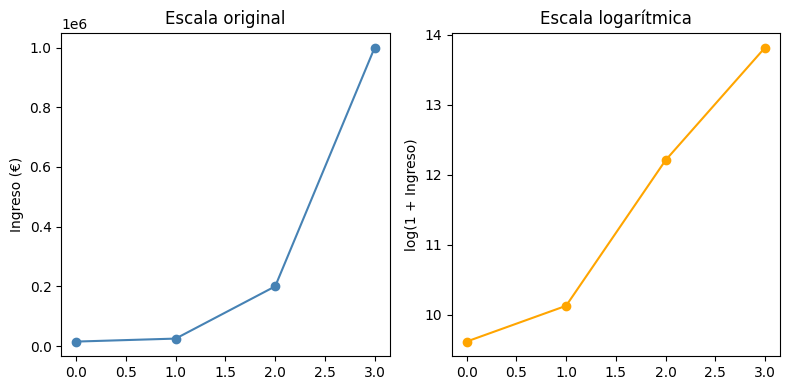

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Datos originales
x = np.array([15_000, 25_000, 200_000, 1_000_000])
x_log = np.log1p(x)  # log(1 + x)

plt.figure(figsize=(8,4)) # ancho 8 pulgadas, alto 4 pulgadas.
plt.subplot(1,2,1) # dibujarías en el segundo subplot, en la derecha
plt.plot(x, 'o-', color='steelblue') # o- es el estilo de linea
plt.title('Escala original')
plt.ylabel('Ingreso (€)')

plt.subplot(1,2,2) # dibujarías en el segundo subplot, en la izq
plt.plot(x_log, 'o-', color='orange')
plt.title('Escala logarítmica')
plt.ylabel('log(1 + Ingreso)')
plt.tight_layout()
plt.show()


### ¿Por qué aplicar un z-score después de una transformación logarítmica?

#### 1. Cada paso tiene un objetivo diferente

- **Transformación logarítmica (`np.log1p`)**:  
  Sirve para **reducir el efecto de valores muy grandes** (outliers) y hacer que la distribución de los datos sea más “normal” o equilibrada.  
  → “Aplana” los datos.

- **Estandarización (Z-score)**:  
  Sirve para **poner todos los datos en la misma escala**, de forma que tengan **media 0** y **desviación estándar 1**.  
  → “Centra y ajusta” los datos.

---

#### 2. Por qué usamos ambas

Cuando un conjunto de datos tiene valores muy grandes **y además** está en una escala muy diferente respecto a otras variables, combinamos ambas técnicas:

1. **Primero el logaritmo**, para que los valores extremos no dominen.
2. **Luego el z-score**, para que todas las variables sean comparables.

Esto mejora el rendimiento de muchos modelos (como regresión lineal, KNN o SVM), que necesitan datos con escalas equilibradas.


## **2.** Normalización logarítmica (log normalization)

La **normalización logarítmica** es una técnica de estandarización útil cuando una variable tiene valores muy dispersos o con gran varianza.

Consiste en aplicar el **logaritmo natural** (`log_e`) a cada valor numérico, lo que **reduce la escala** y hace que los datos se asemejen más a una distribución normal.  
Esto ayuda a:
- Reducir el impacto de valores extremos (outliers).  
- Facilitar el uso de modelos que asumen normalidad.  
- Comparar mejor columnas con escalas muy diferentes.

📘 **Idea clave:**  
El logaritmo transforma multiplicaciones en sumas y comprime las diferencias grandes

> ⚠️ Importante: Solo se puede aplicar sobre valores **positivos**.  
> Si hay ceros o negativos, usa `np.log1p()` (que aplica `log(1+x)`).

A continuación se muestra un ejemplo con código práctico.


In [ ]:
# Ejemplo práctico: aplicar log normalization
import numpy as np
import pandas as pd

# Creamos un DataFrame de ejemplo
df = pd.DataFrame({
    "col1": [2, 3, 5, 7, 11, 13, 17],
    "col2": [10, 100, 500, 1000, 5000, 10000, 50000]
})

print("Primeras filas antes de normalizar:")
print(df.head())

print("\nVarianzas antes de normalizar:")
print(df.var())

# Aplicar transformación logarítmica
df["col2_log"] = np.log(df["col2"])

print("\nPrimeras filas después de aplicar log normalization:")
print(df.head())

print("\nVarianzas después de log normalization:")
print(df[["col1", "col2", "col2_log"]].var())


Primeras filas antes de normalizar:
   col1  col2
0     2    10
1     3   100
2     5   500
3     7  1000
4    11  5000

Varianzas antes de normalizar:
col1    3.090476e+01
col2    3.320697e+08
dtype: float64

Primeras filas después de aplicar log normalization:
   col1  col2  col2_log
0     2    10  2.302585
1     3   100  4.605170
2     5   500  6.214608
3     7  1000  6.907755
4    11  5000  8.517193

Varianzas después de log normalization:
col1        3.090476e+01
col2        3.320697e+08
col2_log    8.363157e+00
dtype: float64


### Interpretación

| Columna | Escala original | Varianza | Comentario |
|----------|----------------|-----------|-------------|
| `col2` | muy amplia (10 → 50,000) | muy alta | domina sobre otras variables |
| `col2_log` | comprimida (2.3 → 10.8) | mucho menor | comparable con otras columnas |

Al aplicar `np.log()`, los valores grandes se reducen proporcionalmente más que los pequeños, **homogeneizando la escala**.

Si tus datos incluyen ceros, puedes usar:

`df["col2_log1p"] = np.log1p(df["col2"])`


## **3.** Escalado de variables (Feature Scaling)

El **escalado de variables** es una técnica de estandarización que ajusta las características numéricas de un dataset para que **todas estén en una misma escala**.  
Esto es especialmente importante cuando los modelos trabajan con **distancias o relaciones lineales**, como en regresión lineal o KNN.

### ¿Por qué escalar?
Si una variable mide "metros" y otra "euros", los valores pueden tener órdenes de magnitud diferentes, lo que puede hacer que el modelo **priorice una variable sobre otra** solo por su tamaño numérico.

### ¿Qué hace el escalado estándar (StandardScaler)?
El método **StandardScaler** de *scikit-learn* transforma cada variable para que:
- Su **media** sea `0`
- Su **desviación estándar** sea `1`

De esta forma, todas las variables son comparables y el modelo aprende mejor las relaciones entre ellas.


### Interpretación

- Antes del escalado, los valores de **Ingresos** eran mucho mayores que los de **Edad**, por lo que esa variable dominaba en el cálculo de distancias o relaciones.  
- Después del escalado, ambas columnas tienen **media 0** y **desviación estándar 1**, por lo que **aportan el mismo peso al modelo**.

## **4.** Estandarización y modelado con K-Nearest Neighbors (KNN)

Ahora que ya conocemos distintas formas de **estandarizar datos**, veamos cómo integrarlas dentro del **flujo de trabajo de modelado** en *scikit-learn*.  
Muchos modelos, como KNN, requieren que los datos estén **escalados correctamente**, para que las distancias entre variables sean comparables y no se distorsionen los resultados.

### Flujo básico del modelado con scikit-learn:

1. **Dividir los datos** en conjunto de entrenamiento y prueba (`train_test_split`).  
   Esto nos permite evaluar el modelo con datos que nunca ha visto.
2. **Estandarizar los datos** con `StandardScaler()`.  
   - Usamos `fit_transform()` en el conjunto de entrenamiento.  
   - Usamos `transform()` en el conjunto de prueba (para evitar *data leakage* o fuga de información).
3. **Entrenar el modelo** con los datos de entrenamiento escalados.
4. **Evaluar el modelo** sobre los datos de prueba usando `.score()` o métricas equivalentes.


In [6]:
# Ejemplo práctico: flujo completo con KNN y estandarización
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_wine

In [2]:
# 1️. Cargar un dataset de ejemplo
data = load_wine()

In [3]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [4]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [6]:
y.sample(100)

,0
146,2
84,1
101,1
144,2
165,2
...,...
72,1
58,0
56,0
103,1


In [7]:
# 2️. Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [8]:
# 3️. Estandarizar los datos (sin mezclar entrenamiento y prueba)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # solo ajusta con entrenamiento
X_test_scaled = scaler.transform(X_test)        # aplica la misma transformación

In [9]:
# 4️. Entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [10]:
# 5️. Evaluar la precisión del modelo
accuracy = knn.score(X_test_scaled, y_test)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}") # .2f 2 decimales float

Precisión del modelo en el conjunto de prueba: 0.93


### Conceptos clave

- **Estandarización previa al modelado:** Asegura que todas las variables tengan el mismo peso en el cálculo de distancias.  
- **Data leakage:** Ocurre cuando el modelo “aprende” información del conjunto de prueba.  
  Por eso se hace `fit` solo sobre los datos de entrenamiento.
- **KNN (K-Nearest Neighbors):** Clasifica cada observación según la etiqueta más común de sus vecinos más cercanos.

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
wines_df = pd.read_csv('/content/drive/MyDrive/wine_types.csv')

In [14]:
wines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Type                          178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wines  178 non-null    float64
 13  Proli

In [15]:
wines_df.describe()

,Type,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [17]:
X = pd.DataFrame(wines_df.drop('Type', axis=1))
y = pd.Series(wines_df['Type'])

In [18]:
X.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [19]:
y.head()

,Type
0,1
1,1
2,1
3,1
4,1


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [21]:
y.unique()

array([1, 2, 3])

In [23]:
# 4️. Entrenar el modelo KNN (SIN ESTANDARIZAR)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [24]:
# 5️. Evaluar la precisión del modelo
accuracy = knn.score(X_test, y_test)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}") # .2f 2 decimales float

Precisión del modelo en el conjunto de prueba: 0.71


VUELVO A CARGAR LOS DATOS

In [186]:
X = pd.DataFrame(wines_df.drop('Type', axis=1))
y = pd.Series(wines_df['Type'])

In [187]:
X.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [27]:
X.describe()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [188]:
X.var()

,0
Alcohol,0.659062
Malic acid,1.248015
Ash,0.075265
Alcalinity of ash,11.152686
Magnesium,203.989335
Total phenols,0.391690
Flavanoids,0.997719
Nonflavanoid phenols,0.015489
Proanthocyanins,0.327595
Color intensity,5.374449


In [189]:
# Logaritmo de Proline
import numpy as np

X['proline_log_valor'] = np.log1p(X['Proline']) # aplica una transformación logarítmica


X.head()


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,proline_log_valor
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,6.971669
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,6.957497
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,7.078342
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,7.300473
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,6.601230


In [30]:
X.drop('Proline', axis=1, inplace=True)

In [31]:
X.var()

,0
Alcohol,0.659062
Malic acid,1.248015
Ash,0.075265
Alcalinity of ash,11.152686
Magnesium,203.989335
Total phenols,0.391690
Flavanoids,0.997719
Nonflavanoid phenols,0.015489
Proanthocyanins,0.327595
Color intensity,5.374449


In [32]:
# Logaritmo de Magnesium

X['magnesium_log_valor'] = np.log1p(X['Magnesium']) # aplica una transformación logarítmica

X.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,proline_log_valor,magnesium_log_valor
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,6.971669,4.852030
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,6.957497,4.615121
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,7.078342,4.624973
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,7.300473,4.736198
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,6.601230,4.779123


In [33]:
X.drop('Magnesium', axis=1, inplace=True)

In [34]:
X.var()

,0
Alcohol,0.659062
Malic acid,1.248015
Ash,0.075265
Alcalinity of ash,11.152686
Total phenols,0.391690
Flavanoids,0.997719
Nonflavanoid phenols,0.015489
Proanthocyanins,0.327595
Color intensity,5.374449
Hue,0.052245


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [36]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [37]:
# 5️. Evaluar la precisión del modelo SIN ESTANDARIZAR
accuracy = knn.score(X_test, y_test)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}") # .2f 2 decimales float

Precisión del modelo en el conjunto de prueba: 0.91


### Prueba combinando Log (Proline y Magnesium) + Escalado (Alcalinity of ash y Color intensity)

In [203]:
X = pd.DataFrame(wines_df.drop('Type', axis=1))
y = pd.Series(wines_df['Type'])

In [204]:
# Divido los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [205]:
X_train.var()

,0
Alcohol,0.643048
Malic acid,1.188691
Ash,0.071125
Alcalinity of ash,11.332573
Magnesium,224.469697
Total phenols,0.396905
Flavanoids,0.918051
Nonflavanoid phenols,0.014050
Proanthocyanins,0.343280
Color intensity,5.596352


In [206]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133 entries, 8 to 159
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       133 non-null    float64
 1   Malic acid                    133 non-null    float64
 2   Ash                           133 non-null    float64
 3   Alcalinity of ash             133 non-null    float64
 4   Magnesium                     133 non-null    int64  
 5   Total phenols                 133 non-null    float64
 6   Flavanoids                    133 non-null    float64
 7   Nonflavanoid phenols          133 non-null    float64
 8   Proanthocyanins               133 non-null    float64
 9   Color intensity               133 non-null    float64
 10  Hue                           133 non-null    float64
 11  OD280/OD315 of diluted wines  133 non-null    float64
 12  Proline                       133 non-null    int64  
dtypes: float64

In [207]:
# Aplico Logaritmo de Proline y Magnesium en train
X_train['Proline'] = np.log1p(X_train['Proline'])
X_train['Magnesium'] = np.log1p(X_train['Magnesium'])

# Aplico la MISMA transformación en test
X_test['Proline'] = np.log1p(X_test['Proline'])
X_test['Magnesium'] = np.log1p(X_test['Magnesium'])

In [208]:
X_train.var()

,0
Alcohol,0.643048
Malic acid,1.188691
Ash,0.071125
Alcalinity of ash,11.332573
Magnesium,0.019888
Total phenols,0.396905
Flavanoids,0.918051
Nonflavanoid phenols,0.014050
Proanthocyanins,0.343280
Color intensity,5.596352


In [209]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133 entries, 8 to 159
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       133 non-null    float64
 1   Malic acid                    133 non-null    float64
 2   Ash                           133 non-null    float64
 3   Alcalinity of ash             133 non-null    float64
 4   Magnesium                     133 non-null    float64
 5   Total phenols                 133 non-null    float64
 6   Flavanoids                    133 non-null    float64
 7   Nonflavanoid phenols          133 non-null    float64
 8   Proanthocyanins               133 non-null    float64
 9   Color intensity               133 non-null    float64
 10  Hue                           133 non-null    float64
 11  OD280/OD315 of diluted wines  133 non-null    float64
 12  Proline                       133 non-null    float64
dtypes: float64

In [ ]:
# Estandarizo Alcalinity of ash y Color intensity
scaler = StandardScaler()
X_train[['Alcalinity of ash', 'Color intensity']] = scaler.fit_transform(X_train[['Alcalinity of ash', 'Color intensity']])
X_test[['Alcalinity of ash', 'Color intensity']] = scaler.transform(X_test[['Alcalinity of ash', 'Color intensity']])

In [211]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133 entries, 8 to 159
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       133 non-null    float64
 1   Malic acid                    133 non-null    float64
 2   Ash                           133 non-null    float64
 3   Alcalinity of ash             133 non-null    float64
 4   Magnesium                     133 non-null    float64
 5   Total phenols                 133 non-null    float64
 6   Flavanoids                    133 non-null    float64
 7   Nonflavanoid phenols          133 non-null    float64
 8   Proanthocyanins               133 non-null    float64
 9   Color intensity               133 non-null    float64
 10  Hue                           133 non-null    float64
 11  OD280/OD315 of diluted wines  133 non-null    float64
 12  Proline                       133 non-null    float64
dtypes: float64

In [212]:
X_train.describe()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,133.000000,133.000000,133.000000,1.330000e+02,133.000000,133.000000,133.000000,133.000000,133.000000,1.330000e+02,133.000000,133.000000,133.000000
mean,12.968271,2.332932,2.367744,4.140381e-16,4.604953,2.282481,1.993383,0.361429,1.604586,-2.070190e-16,0.949744,2.594737,6.537130
std,0.801903,1.090271,0.266693,1.003781e+00,0.141025,0.630004,0.958150,0.118534,0.585901,1.003781e+00,0.225866,0.685365,0.404041
min,11.030000,0.740000,1.360000,-2.713862e+00,4.262680,0.980000,0.340000,0.130000,0.420000,-1.581762e+00,0.480000,1.270000,5.631212
25%,12.370000,1.610000,2.200000,-7.458916e-01,4.488636,1.700000,1.220000,0.270000,1.250000,-8.307283e-01,0.780000,1.960000,6.216606
50%,12.990000,1.810000,2.360000,8.900480e-02,4.595120,2.400000,2.140000,0.340000,1.570000,-1.390981e-01,0.960000,2.780000,6.516193
75%,13.560000,3.120000,2.560000,5.362708e-01,4.691348,2.800000,2.780000,0.430000,1.950000,5.270733e-01,1.090000,3.140000,6.893656
max,14.830000,5.800000,3.220000,3.070778e+00,5.093750,3.880000,3.740000,0.630000,3.580000,3.391186e+00,1.710000,3.920000,7.323831


In [213]:
X_train.var()

,0
Alcohol,0.643048
Malic acid,1.188691
Ash,0.071125
Alcalinity of ash,1.007576
Magnesium,0.019888
Total phenols,0.396905
Flavanoids,0.918051
Nonflavanoid phenols,0.014050
Proanthocyanins,0.343280
Color intensity,1.007576


In [214]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [215]:
accuracy = knn.score(X_test, y_test)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}") # .2f 2 decimales float

Precisión del modelo en el conjunto de prueba: 0.91


### PRUEBO APLICANDO LOG Y ESCALANDO TODAS

In [11]:
X = pd.DataFrame(wines_df.drop('Type', axis=1))
y = pd.Series(wines_df['Type'])

In [12]:
# Divido los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [13]:
# LOG
X_train['Proline'] = np.log1p(X_train['Proline'])
X_train['Magnesium'] = np.log1p(X_train['Magnesium'])
X_test['Proline'] = np.log1p(X_test['Proline'])
X_test['Magnesium'] = np.log1p(X_test['Magnesium'])

In [14]:
X_train.var()

,0
Alcohol,0.643048
Malic acid,1.188691
Ash,0.071125
Alcalinity of ash,11.332573
Magnesium,0.019888
Total phenols,0.396905
Flavanoids,0.918051
Nonflavanoid phenols,0.014050
Proanthocyanins,0.343280
Color intensity,5.596352


In [15]:
# 2. Escalo TODO
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
x_train_df_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
x_train_df_scaled.var()

,0
Alcohol,1.007576
Malic acid,1.007576
Ash,1.007576
Alcalinity of ash,1.007576
Magnesium,1.007576
Total phenols,1.007576
Flavanoids,1.007576
Nonflavanoid phenols,1.007576
Proanthocyanins,1.007576
Color intensity,1.007576


In [17]:
x_train_df_scaled.sample(5)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
132,0.640557,-0.610343,1.024717,0.834448,-0.748384,0.505900,-0.935930,1.342834,1.174269,2.860795,-1.687640,-1.193258,-0.262843
120,-0.561122,0.089367,-0.744271,0.387182,-0.827913,0.426236,0.289790,-0.858930,-0.658884,-1.276257,-0.221071,0.271335,-1.863844
90,-1.474899,-0.186834,1.551650,2.623512,-0.514994,-0.242947,0.258361,1.850933,0.266259,-0.851944,0.090019,-0.226626,-0.970888
61,0.340137,1.516407,-0.292615,-0.656438,0.280708,0.569632,0.666935,-0.350830,0.094936,-0.274878,-0.576603,0.593546,-0.033708
124,-0.123010,2.096430,0.422508,0.536271,-0.989687,-0.928063,-1.407361,0.919418,-1.275646,1.121112,-1.820964,-1.076090,-0.242920


In [27]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_test_scaled, y_test)

In [28]:

print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.3f}") # .2f 2 decimales float

Precisión del modelo en el conjunto de prueba: 0.956
